In [1]:
import pandas as pd
import pandahouse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import swifter
from scipy import stats
%matplotlib inline

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250220'
}

In [36]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-01-31' and '2025-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


Данные CTR для групп 1 и 2 на графике

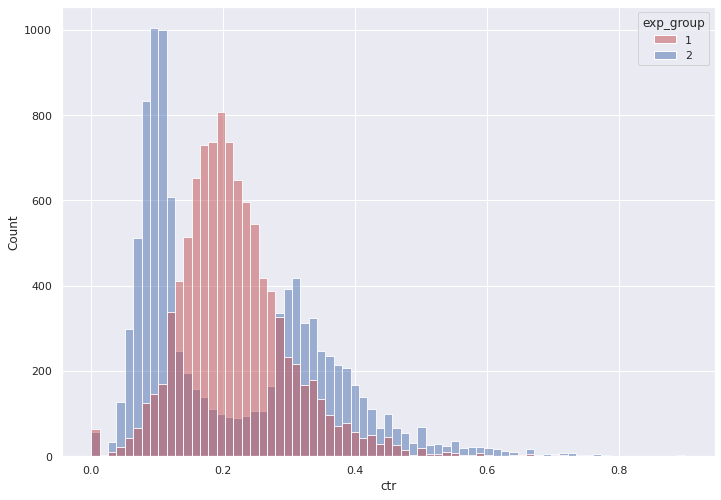

In [6]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

t-тест

In [5]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Тест Манна-Уитни

In [7]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Сглаженный CTR

<Axes: xlabel='ctr', ylabel='Count'>

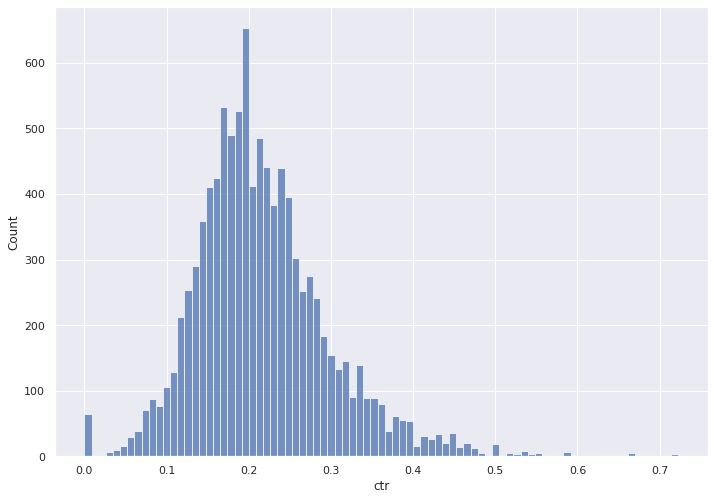

In [15]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr, 
             kde = False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

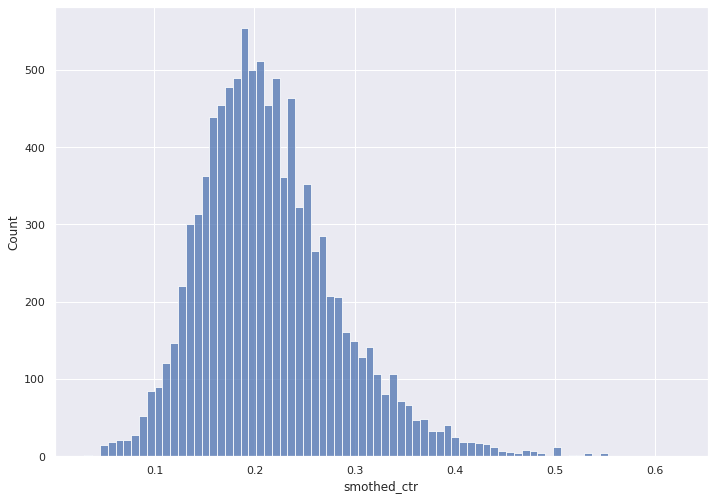

In [16]:
#сглаженный CTR для контрольной группы
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_ctr, 
             kde = False)

<Axes: xlabel='ctr', ylabel='Count'>

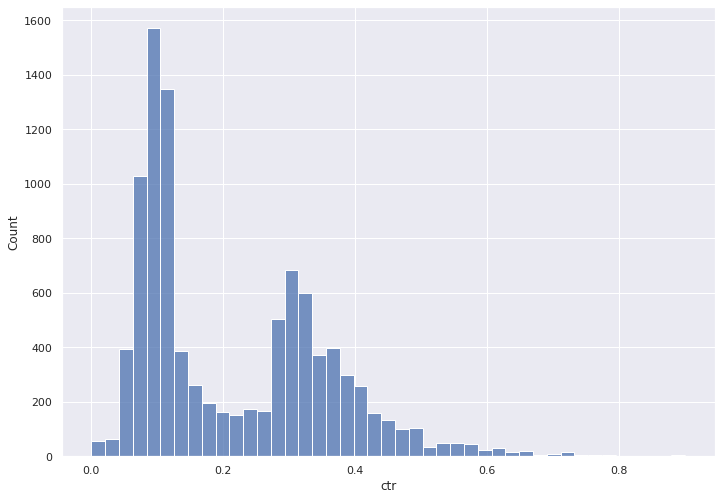

In [17]:
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr, 
             kde = False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

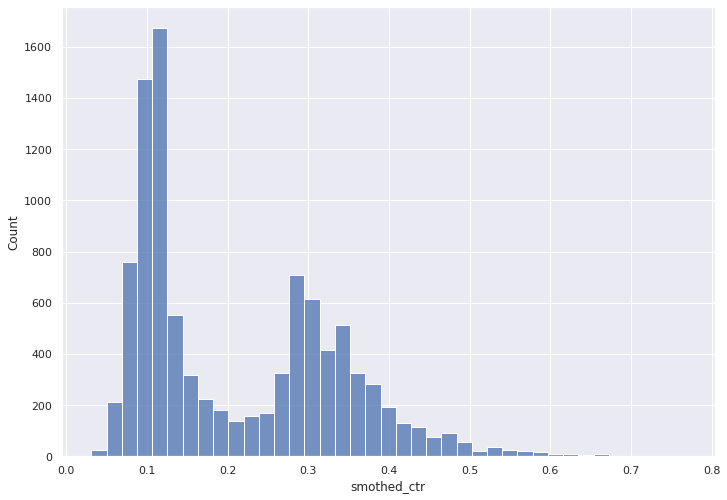

In [37]:
#сглаженный CTR для 2 группы
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_ctr, 
             kde = False)

Пуассоновский бутстреп для подсчета разницы в CTR

<Axes: ylabel='Count'>

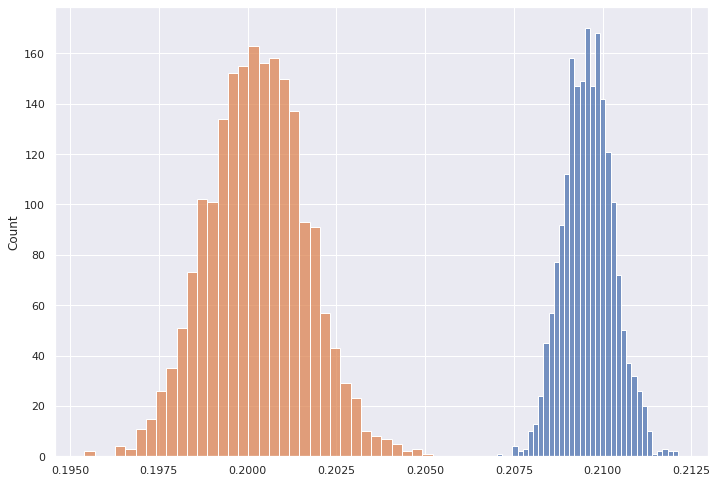

In [19]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

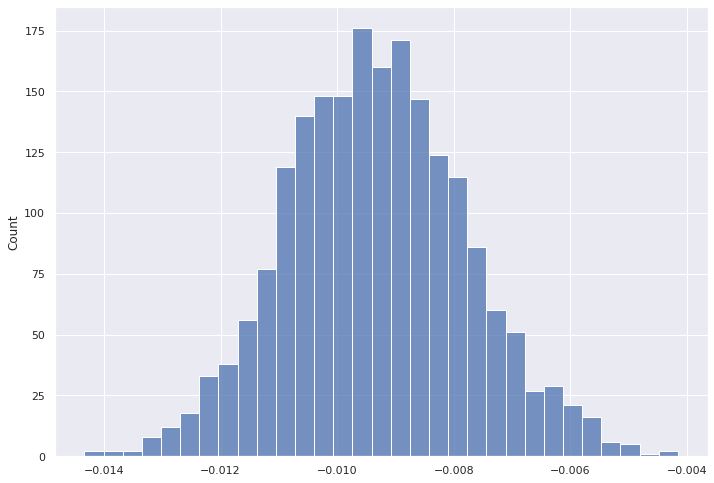

In [31]:
sns.histplot(ctr2 - ctr1)

Бакетное преобразование

In [32]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-01-31' and '2025-02-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни поверх бакетного преобразования
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [33]:
#t-тест поверх бакетного преобразования

stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

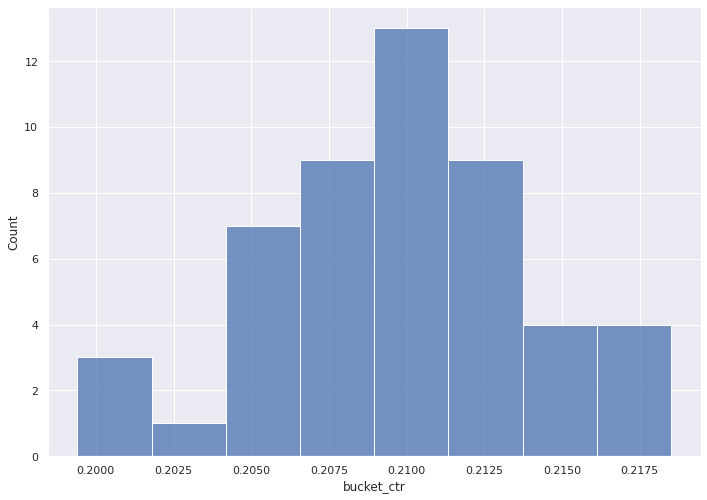

In [34]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<Axes: xlabel='ctr9', ylabel='Count'>

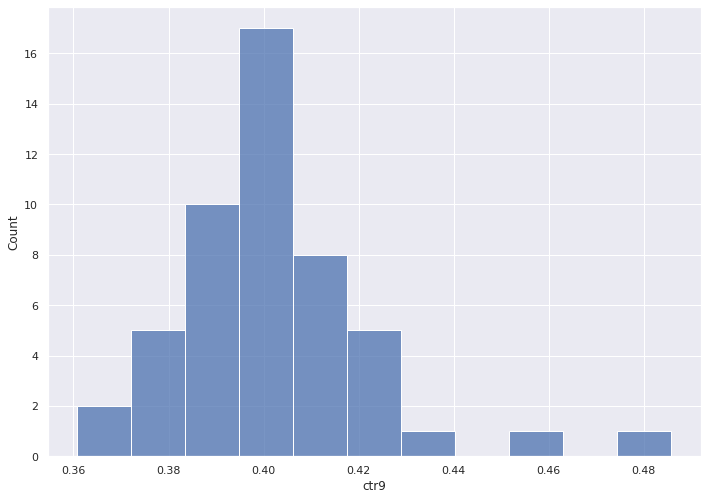

In [35]:
sns.histplot(df[df.exp_group == 2].ctr9)

Тест Манна-Уитни и t-тест поверх бакетизации показали маленькие p-value. На основе этой информации можно сделать вывод, что разница между двумя группами статистически значимая. Соответственно, мы отвергаем нулевую гипотезу и делаем вывод о том, что разница в CTR есть. При этом важно отметить, что t-тест по "сырым" пользовательским CTR (без бакетизации) показал высокое p-value — значимой разницы там не выявлено. Это может быть связано с высокой дисперсией и выбросами в данных.

Бутстрап также подтвердил разницу между группами: распределения бутстрапных CTR визуально отличаются, что дополнительно подтверждает гипотезу о снижении вовлечённости в экспериментальной группе. Таким образом, выводы поддерживаются несколькими методами.

Тесты сработали так, потому что данные имеют значительную разницу в CTR между группами, особенно после обработки (бакетизация, бутстрап).

Потенциальная ситуация, когда такое могло произойти:
    1.Проблема с реализацией нового функционала. Если тестирование не было произведено должным образом, это могло привести к снижению пользовательской активности.
    2.Ситуация, когда сам функционал работает корректно, но алгоритмы не понравились пользователям. Данные экспериментальной группы не имеют нормального распределения, содержат выбросы.     Возможные причины: недовольство пользователей, разнообразная реакция аудитории.

Так как CTR в экспериментальной группе значительно меньше, чем в контрольной, можно сделать вывод о том, что новый алгоритм негативно влияет на вовлечённость пользователей.

Заключение: новый алгоритм не стоит раскатывать на всю пользовательскую аудиторию.

Рекомендации:
    1.Провести анализ на предмет технических ошибок.
    2.Изучить предпочтения пользователей (опрос, сбор отзывов).
    3.Оптимизировать функционал с учётом полученных данных и обратной связи.